# 2014 Chicago Crimes Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

Populating the interactive namespace from numpy and matplotlib


# <u> 1. Data Set Description <u>

Data source: https://www.kaggle.com/currie32/crimes-in-chicago

<ul>
<li><b> df </b>is a dataset of crimes (with the exception of murders where data exists for each victim) that occurred in Chicago from 2012 to 2016. </li>
<li><b>Each row</b> reports an incident of crime. </li>
</ul>

Important <b>attributes</b> for each crime are:
<ol>
<li><b>Type</b>: The primary description of Types of Crime.</li>
<li><b>Domestic</b>: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.</li>
<li><b>Location Description</b>: Description of the location where the incident occurred.</li>
<li><b>Arrest</b>: Indicates whether an arrest was made.</li>
<li><b>Community Area</b>: Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6. </li>
<li><b>Date</b>: Date when the incident occurred. This is sometimes a best estimate.</li>
</ol>

In [3]:
df = pd.read_csv("Chicago_Crimes_2012_to_2017.csv")

In [4]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


# <u> 2. Data Preparation </u>

### Data Selection

The original complete dataset includes 'Unnamed:', 'ID', 'Case Number', 'Timestamp', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'YC oordinate', 'Year', 'Updated Timestamp', 'Latitude', 'Longitude', 'Location'. <br>

Data are selected based on its theorectical influency and uniqueness. <br>

For Crime Types, we selected <b>'Primary Type'</b> as our main indicator, because the 'Description' of crime types is unclear and redundant. 'FBICode' is unituitive to understand. <br>

For Crime Location, we selected <b>'Location Description'</b> and <b>'Community Area'</b>, because 'Location Description' portraits the societal location and 'Community Area' indicates the geographic location of the crime scenes. Other geographic paratemers 'Block', 'Beat', 'District', 'Ward', XCoordinate', 'YCoordinate', 'Latitude', 'Longitude', 'Location', either present a over broad geographic region, or specify a precise location that cannot be generalized. <br>

Thus, our dataframe is chosen as below:

In [5]:
df = df[['ID', 'Case Number', 'Date', 'Primary Type','Domestic', 'Location Description', 'Arrest', 'Community Area']]

### Data Cleaning

We would like to look into whether there is a certain pattern for different year, month, day, or hour. So we transform timestamps (Origial <b>'Date'</b> variable) into <b>Year</b>, <b>Month</b>, <b>Day</b>, and <b>Hour</b>.

In [6]:
df['Year'] = df.Date.astype(np.datetime64).dt.year

KeyboardInterrupt: 

In [ ]:
df['Month'] = df.Date.astype(np.datetime64).dt.month

In [ ]:
df['Day'] = df.Date.astype(np.datetime64).dt.day

In [ ]:
df['Hour'] = df.Date.astype(np.datetime64).dt.hour

Due to our computer process ability, we decided to cunduct the further analysis focusing on only data in 2014.<br>
Since <b>'ID'</b> and <b>'Case Number'</b> are unique identifiers of the data, we dropped them off.

In [ ]:
df = df[df.Year == 2014]

In [ ]:
df = df.drop(columns = ["ID", "Case Number", "Date", "Year"])

Rename Data Columns

In [ ]:
df = df.rename(columns = {"Primary Type":"Type", "Location Description":"Location", "Community Area":"Community"})

We saved the cleaned data set as a csv file, so we don't have to spend time cleaning the data each time working on the data set.

In [ ]:
df.to_csv("Final_Chicago_Crime_File.csv", index = False)

In [7]:
df = pd.read_csv("Final_Chicago_Crime_File.csv")

In [8]:
df2 = df.copy()

Make dummies of <b>Location</b>, <b>Type</b>, and <b>Community</b>.

In [9]:
df2 = pd.get_dummies(data = df2, columns = ['Location','Type','Community'])

In [20]:
df2 = df2.dropna()

In [21]:
df2.Domestic = df2.Domestic * 1
df2.Arrest = df2.Arrest * 1

In [22]:
df2.head()

,Domestic,Arrest,Month,Day,Hour,Location_ABANDONED BUILDING,Location_AIRCRAFT,Location_AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,Location_AIRPORT BUILDING NON-TERMINAL - SECURE AREA,Location_AIRPORT EXTERIOR - NON-SECURE AREA,...,Community_68.0,Community_69.0,Community_70.0,Community_71.0,Community_72.0,Community_73.0,Community_74.0,Community_75.0,Community_76.0,Community_77.0
0,0,0,11,1,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,12,10,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,26,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,7,1,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# <u> 3. Interesting Finding</u>

### There are a few crime patterns for <b>prostitution crimes</b> in Chicago:
<ol> 
    <li>Prostition crimes happened mostly on <b>street</b></li>
    <li><b>After 18:30</b>, if a crime happens in <b>hotel/motel</b>, it's more likely to be prostitution than other crimes.</li>
</ol>

# <u> 4. Advance Analysis</u>

## Clustering

In [23]:
from sklearn.cluster import KMeans

Normalize the data

In [24]:
df3 = df2.copy()
df3 = (df3 - df3.mean()) / df3.std()

In [25]:
clu = KMeans(n_clusters = 5, random_state = 0)

In [26]:
clu.fit(df3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [27]:
df2["Cluster"] = clu.labels_

In [28]:
df2.groupby("Cluster")["Domestic", "Arrest", "Month", "Day", "Hour", "Type_HOMICIDE",\
                       "Type_PUBLIC INDECENCY", "Type_GAMBLING", "Type_NARCOTICS" ,"Type_PROSTITUTION",\
                       "Type_LIQUOR LAW VIOLATION", "Type_INTERFERENCE WITH PUBLIC OFFICER", "Type_WEAPONS VIOLATION", \
                       "Type_PUBLIC PEACE VIOLATION", "Type_OTHER NARCOTIC VIOLATION", "Type_OBSCENITY",\
                       "Type_CRIMINAL TRESPASS", "Location_STREET", "Location_RESIDENCE", "Location_APARTMENT",\
                       "Location_HOTEL/MOTEL","Location_SIDEWALK"].mean().T

Cluster,0,1,2,3,4
Domestic,0.271932,0.349974,0.031483,0.004375,0.003021
Arrest,0.238674,0.218507,0.097235,0.955960,0.074018
Month,6.493794,6.623917,6.677585,6.417267,6.492447
Day,15.453465,15.738433,15.750484,15.584037,15.906344
Hour,13.270727,13.036580,12.829517,15.111968,11.800604
Type_HOMICIDE,0.000052,0.000213,0.001812,0.004110,0.000000
Type_PUBLIC INDECENCY,0.000000,0.000000,0.000000,0.000221,0.000000
Type_GAMBLING,0.000052,0.000000,0.000000,0.008662,0.000000
Type_NARCOTICS,0.005761,0.000011,0.000000,0.637336,0.000000
Type_PROSTITUTION,0.000105,0.000000,0.000000,0.035864,0.000000


Through clustering, we find that <b>PROSTITUTION Crimes</b> mostly happen in <b>Cluster 3</b>, so we look into Cluster 3.

### Cluster Analysis I

In [31]:
df2.groupby("Cluster").size()

Cluster
0     19093
1     89201
2    120317
3     45254
4       662
dtype: int64

In [32]:
cluster_0 = df2[df2.Cluster == 0]
cluster_1 = df2[df2.Cluster == 1]
cluster_2 = df2[df2.Cluster == 2]
cluster_3 = df2[df2.Cluster == 3]
cluster_4 = df2[df2.Cluster == 4]

### Investigation: Location

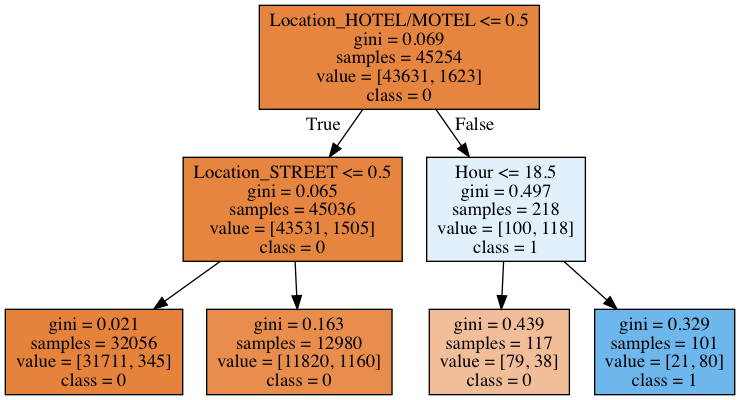

In [33]:
tree_x = cluster_3.drop(columns = ['Type_ASSAULT', 'Type_BATTERY', 'Type_BURGLARY',\
       'Type_CONCEALED CARRY LICENSE VIOLATION', 'Type_CRIM SEXUAL ASSAULT',\
       'Type_CRIMINAL DAMAGE', 'Type_CRIMINAL TRESPASS',\
       'Type_DECEPTIVE PRACTICE', 'Type_GAMBLING', 'Type_HOMICIDE',\
       'Type_HUMAN TRAFFICKING', 'Type_INTERFERENCE WITH PUBLIC OFFICER',\
       'Type_INTIMIDATION', 'Type_KIDNAPPING', 'Type_LIQUOR LAW VIOLATION',\
       'Type_MOTOR VEHICLE THEFT', 'Type_NARCOTICS', 'Type_NON - CRIMINAL',\
       'Type_NON-CRIMINAL', 'Type_NON-CRIMINAL (SUBJECT SPECIFIED)',\
       'Type_OBSCENITY', 'Type_OFFENSE INVOLVING CHILDREN',\
       'Type_OTHER NARCOTIC VIOLATION', 'Type_OTHER OFFENSE',\
       'Type_PROSTITUTION', 'Type_PUBLIC INDECENCY',\
       'Type_PUBLIC PEACE VIOLATION', 'Type_ROBBERY', 'Type_SEX OFFENSE',\
       'Type_STALKING', 'Type_THEFT', 'Type_WEAPONS VIOLATION'])

tree_y = cluster_3.Type_PROSTITUTION

dt = tree.DecisionTreeClassifier(max_depth = 2)

dt.fit(tree_x, tree_y)

dt_feature_names = list(tree_x.columns)
dt_target_names = np.array(tree_y.unique(), dtype = np.str)
tree.export_graphviz(dt, out_file = "tree.dot",
                    feature_names = dt_feature_names, class_names = dt_target_names,
                    filled = True)

graph = pydotplus.graph_from_dot_file("tree.dot")
Image(graph.create_png())

We observed a few crime patterns for <b>prostitution</b>: 
<ol>
    <li>A large number of <b>prostition crimes</b> happened on <b>street</b>.</li>
    <li>If the location is <b>Hotel/Motel</b> and the crime occured <b>after 18:30 pm</b>, it is more likely to be <b>prostition</b> than other crimes.</li>
</ol>

# <u> 5. Validity of the Finding </u>

Do we have enough sample to claim it? Yes! 99% of prostitutes are included in Cluster 3.

In [38]:
cluster_3[cluster_3.Type_PROSTITUTION == 1].Domestic.count() / df2[df2.Type_PROSTITUTION == 1].Domestic.count()

0.9987692307692307

Binary histogram on whether a prostitute wanders on street from main dataset.

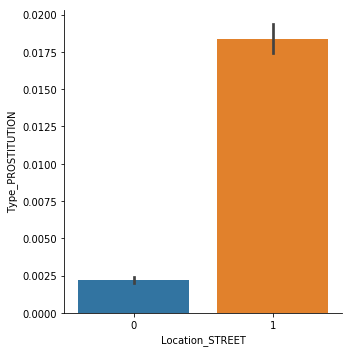

In [39]:
sns.catplot(data = df2, x = "Location_STREET", y = "Type_PROSTITUTION", kind = "bar")

In [40]:
df[df.Type == "PROSTITUTION"].groupby("Location").size()

Location
ALLEY                                19
APARTMENT                             1
CHA HALLWAY/STAIRWELL/ELEVATOR        1
COMMERCIAL / BUSINESS OFFICE          5
CTA BUS STOP                          2
GAS STATION                           1
HOTEL/MOTEL                         118
OTHER                                12
PARK PROPERTY                        34
PARKING LOT/GARAGE(NON.RESID.)        9
POLICE FACILITY/VEH PARKING LOT       1
RESIDENCE                            12
RESIDENTIAL YARD (FRONT/BACK)         1
RESTAURANT                            1
SIDEWALK                            237
SMALL RETAIL STORE                    1
SPORTS ARENA/STADIUM                  1
STREET                             1160
TAXICAB                               1
VACANT LOT/LAND                       1
VEHICLE NON-COMMERCIAL                7
dtype: int64

The below bar plot verifies our result as: <b>after 18:30</b>, if a crime happens in <b>hotel/motel</b>, it's more likely to be <b>prostitution</b> than other crimes.

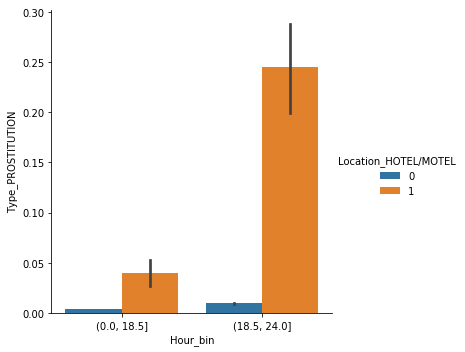

In [24]:
df4 = df2.copy()
df4["Hour_bin"] = pd.cut(df4["Hour"], bins = [0, 18.5, 24])
sns.catplot(data = df4, x = "Hour_bin", y = "Type_PROSTITUTION", hue = "Location_HOTEL/MOTEL", kind = "bar")

In [59]:
df5 = df2.copy()
df5.rename(columns={"Location_HOTEL/MOTEL":"Location_HOTEL_MOTEL"}, inplace=True)
df5 = df5.loc[(df5.Hour>=18.5) & df5.Location_HOTEL_MOTEL == 1]

In [63]:
df5.loc[df5.Type_PROSTITUTION==1].Domestic.count()/df5.Domestic.count()

0.24464831804281345

# <u> 6.  Managerial Insights</u>

There are a few crime patterns for <b>prostitution crimes</b>:
<ol> 
    <li>Prostition crimes happened mostly on <b>street</b></li>
    <li><b>After 18:30</b>, if a crime happens in <b>hotel/motel</b>, it's more likely to be prostitution than other crimes.</li>
</ol>

### Therefore, increasing patrols on street and cooperate with hotel/motels at night will effictively strike prostitution crimes.